In [1]:
from biopandas.pdb import PandasPdb
pdf = PandasPdb().read_pdb('../data/pdb_files/PTGA_ECOLI_model1_clean.pdb')  # 3EZW, but only monomer
adf = pdf.df['ATOM']
cadf = adf[adf["atom_name"]=="CA"]
cadf = cadf.set_index("residue_number")
cadf = cadf[cadf["alt_loc"].isin(['A', ''])]  # removing the 'B' residue alternative locations. I could also find the average between the two positions if necessary to account for both.
cadf.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
residue_number,,,,,,,,,,,,,,,,,,,,
1,ATOM,2,,CA,,MET,,X,,,-37.428,33.690,44.681,1.0,80.37,,1SG,C,NaN,1
2,ATOM,10,,CA,,GLY,,X,,,-36.389,34.157,41.107,0.0,81.32,,1SG,C,NaN,9
3,ATOM,14,,CA,,LEU,,X,,,-33.575,36.428,40.154,0.0,64.68,,1SG,C,NaN,13
4,ATOM,22,,CA,,PHE,,X,,,-32.934,39.527,42.183,0.0,62.75,,1SG,C,NaN,21
5,ATOM,33,,CA,,ASP,,X,,,-33.666,41.617,39.120,0.0,78.03,,1SG,C,NaN,32


In [2]:
import pandas as pd

aa_mut_cnt_df = pd.read_csv("./crr_pub_aa_muts.csv")
aa_mut_cnt_df.head()

,AA position,mutation type,disrupt coding seq,disrupt func,disrupt struct,study,study color,mutation count,name,color,residue index
0,34,SNP,0,1,1,GYD,#AEC7E8,1,SNP 34,#8C564B,34
1,39,SNP,0,1,1,GYD,#AEC7E8,1,SNP 39,#8C564B,39
2,44,SNP,0,0,0,GYD,#AEC7E8,1,SNP 44,black,44
3,48,SNP,0,1,1,GYD,#AEC7E8,1,SNP 48,#8C564B,48
4,50,SNP,0,1,1,GYD,#AEC7E8,1,SNP 50,#8C564B,50


In [3]:
gff_df = pd.read_csv("./Crr_feats.csv")
gff_df = gff_df[~(gff_df.feature.isin(["Turn", "Helix", "Beta strand", 'PTS Crr type-1 domain', 'Crr 1 PFAM domain']))].copy()
gff_df.head()

,seqname,source,feature,AA start,AA end,score,strand,frame,attribute,9,color,residue index start,residue index end
0,P69783,UniProtKB,Chain,2,169,.,.,.,ID=PRO_0000186532;Note=PTS system glucose-spec...,NaN,white,2,169
2,P69783,UniProtKB,Crr activity tele-phosphohistidine intermediate,91,91,.,.,.,Note=Tele-phosphohistidine intermediate%3B for...,NaN,#B79A20,91,91
3,P69783,UniProtKB,GlpK Zinc binding site,76,76,.,.,.,Note=Zinc%3B shared with glycerol kinase;Ontol...,NaN,#439894,76,76
4,P69783,UniProtKB,GlpK Zinc binding site,91,91,.,.,.,Note=Zinc%3B shared with glycerol kinase;Ontol...,NaN,#439894,91,91
5,P69783,UniProtKB,Phospho-donor active site,76,76,.,.,.,Note=Important for phospho-donor activity;Onto...,NaN,#83BCB6,76,76


In [4]:
# filtering out all truncating mutations since currently not considering truncations for 3D clustering
aa_mut_cnt_df = aa_mut_cnt_df[aa_mut_cnt_df["color"] != "#CF000F"].copy()

In [5]:
dist_aa_df = aa_mut_cnt_df.copy()

# don't care about about multiple muts on same AA for now
dist_aa_df = dist_aa_df[["residue index", "name",
#                          "selection pressure"
                        ]]
dist_aa_df = dist_aa_df.drop_duplicates()
# display(dist_aa_df)

for _, r in gff_df.iterrows():
    if r["feature"] != "Chain":
        for res_idx in range(r["residue index start"], r["residue index end"] + 1): 
            dist_aa_df = dist_aa_df.append({"residue index": res_idx, "name": r["feature"] + " residue " + str(res_idx)}, ignore_index=True)

dist_aa_df["residue index"] = dist_aa_df["residue index"].astype(int)

dist_aa_df['coords'] = dist_aa_df.apply(lambda r:
                                        [
                                            cadf.at[r["residue index"], "x_coord"],
                                            cadf.at[r["residue index"], "y_coord"],
                                            cadf.at[r["residue index"], "z_coord"],
                                        ],
                                        axis=1)
dist_aa_df

,residue index,name,coords
0,34,SNP 34,"[-5.692, 33.227, 35.209]"
1,39,SNP 39,"[-3.284, 34.414, 26.285]"
2,44,SNP 44,"[1.68, 35.878, 32.796]"
3,48,SNP 48,"[-2.317, 42.424, 35.885]"
4,50,SNP 50,"[-7.145, 38.451, 38.73]"
...,...,...,...
180,95,PtsG Crr interface residue 95,"[-9.49, 37.487, 20.303]"
181,97,PtsG Crr interface residue 97,"[-12.499, 41.658, 18.724]"
182,98,PtsG Crr interface residue 98,"[-12.548, 39.553, 15.551]"
183,100,PtsG Crr interface residue 100,"[-16.502, 42.908, 15.426]"


In [6]:
import numpy as np
def _get_dist_mat_label(r):
    lbl = r["name"]
    if ("SNP" in r["name"]) or ("INS" in r["name"]):
        lbl = "mut res " + str(r["residue index"])
    return lbl
        

dist_aa_df['dist mat label'] = dist_aa_df.apply(lambda r: _get_dist_mat_label(r), axis=1)
dist_aa_df = dist_aa_df.set_index("dist mat label")

dist_aa_df.head()

,residue index,name,coords
dist mat label,,,
mut res 34,34,SNP 34,"[-5.692, 33.227, 35.209]"
mut res 39,39,SNP 39,"[-3.284, 34.414, 26.285]"
mut res 44,44,SNP 44,"[1.68, 35.878, 32.796]"
mut res 48,48,SNP 48,"[-2.317, 42.424, 35.885]"
mut res 50,50,SNP 50,"[-7.145, 38.451, 38.73]"


In [7]:
import numpy as np


def get_3D_res_dist(feat_res_1, feat_res_2):
    dist = np.nan
    feat_res_1_coords = dist_aa_df.at[feat_res_1, "coords"]
    feat_res_2_coords = dist_aa_df.at[feat_res_2, "coords"]
    dist = np.sqrt((feat_res_2_coords[0] - feat_res_1_coords[0])**2
                      + (feat_res_2_coords[1] - feat_res_1_coords[1])**2
                      + (feat_res_2_coords[2] - feat_res_1_coords[2])**2)
    return dist


dist_mat = pd.DataFrame(np.nan, columns=dist_aa_df.index, index=dist_aa_df.index)
for ir in dist_mat.index:
    for ic in dist_mat.columns:
        dist_mat.at[ir, ic] = get_3D_res_dist(ir, ic)
dist_mat.head()

dist mat label,mut res 34,mut res 39,mut res 44,mut res 48,mut res 50,mut res 72,mut res 93,mut res 138,Crr activity tele-phosphohistidine intermediate residue 91,GlpK Zinc binding site residue 76,...,PtsG Crr interface residue 76,PtsG Crr interface residue 77,PtsG Crr interface residue 89,PtsG Crr interface residue 91,PtsG Crr interface residue 94,PtsG Crr interface residue 95,PtsG Crr interface residue 97,PtsG Crr interface residue 98,PtsG Crr interface residue 100,PtsG Crr interface residue 142
dist mat label,,,,,,,,,,,,,,,,,,,,,
mut res 34,0.000000,9.319078,8.197363,9.820001,6.465201,21.043029,12.283200,7.027852,12.034678,18.093710,...,18.093710,16.425249,12.906196,12.034678,12.548806,15.961242,19.727449,21.759135,24.534566,13.281435
mut res 39,9.319078,0.000000,8.317314,12.540143,13.641214,18.096330,9.876185,9.976917,11.258270,15.638462,...,15.638462,15.091899,14.575226,11.258270,7.278160,9.151070,13.948494,15.081438,19.099252,15.748381
mut res 44,8.197363,8.317314,0.000000,8.268497,10.941358,22.307463,16.342873,12.409135,15.232022,21.125580,...,21.125580,19.234264,15.146751,15.232022,14.740152,16.835463,20.796000,22.656823,26.109824,12.733306
mut res 48,9.820001,12.540143,8.268497,0.000000,6.869377,18.137458,16.206577,10.368917,12.163448,18.263700,...,18.263700,15.245073,8.841601,12.163448,15.767242,17.850059,19.968971,22.943137,24.900184,4.569772
mut res 50,6.465201,13.641214,10.941358,6.869377,0.000000,19.508415,14.539907,7.345082,11.489227,17.778834,...,17.778834,15.054080,9.194260,11.489227,15.489798,18.600609,20.956865,23.825886,25.504798,8.685592


In [8]:
df = gff_df[["feature", "color"]].drop_duplicates()
feat_to_color_d = dict()
for _, r in df.iterrows():
    feat_to_color_d[r["feature"]] = r["color"]
feat_to_color_d

{'Chain': 'white',
 'Crr activity tele-phosphohistidine intermediate': '#B79A20',
 'GlpK Zinc binding site': '#439894',
 'Phospho-donor active site': '#83BCB6',
 'Phosphohistidine by HPr': '#AD34AD',
 'Membrane interface': '#B279A2',
 'N6-acetyllysine site': '#FF9D98',
 'FrsA Crr interface': '#4C78A8',
 'PtsI Crr interface': '#9ECAE9',
 'Crr Crr interface': '#17BECF',
 'GlpK Crr interface': '#E15759',
 'PtsH Crr interface': '#FFBF79',
 'MalK Crr interface': '#54A24B',
 'PtsG Crr interface': '#88D27A'}

In [9]:
res_feat_dist_df = dist_mat[dist_mat.index.str.contains("mut")]
res_feat_dist_df = res_feat_dist_df.T
res_feat_dist_df = res_feat_dist_df[~(res_feat_dist_df.index.str.contains("mut"))]

col_colors = []
for _, r in res_feat_dist_df.iterrows():
    feat = r.name[:r.name.find(" residue")]
    ftc = feat_to_color_d[feat]
    col_colors.append(ftc)
# col_colors

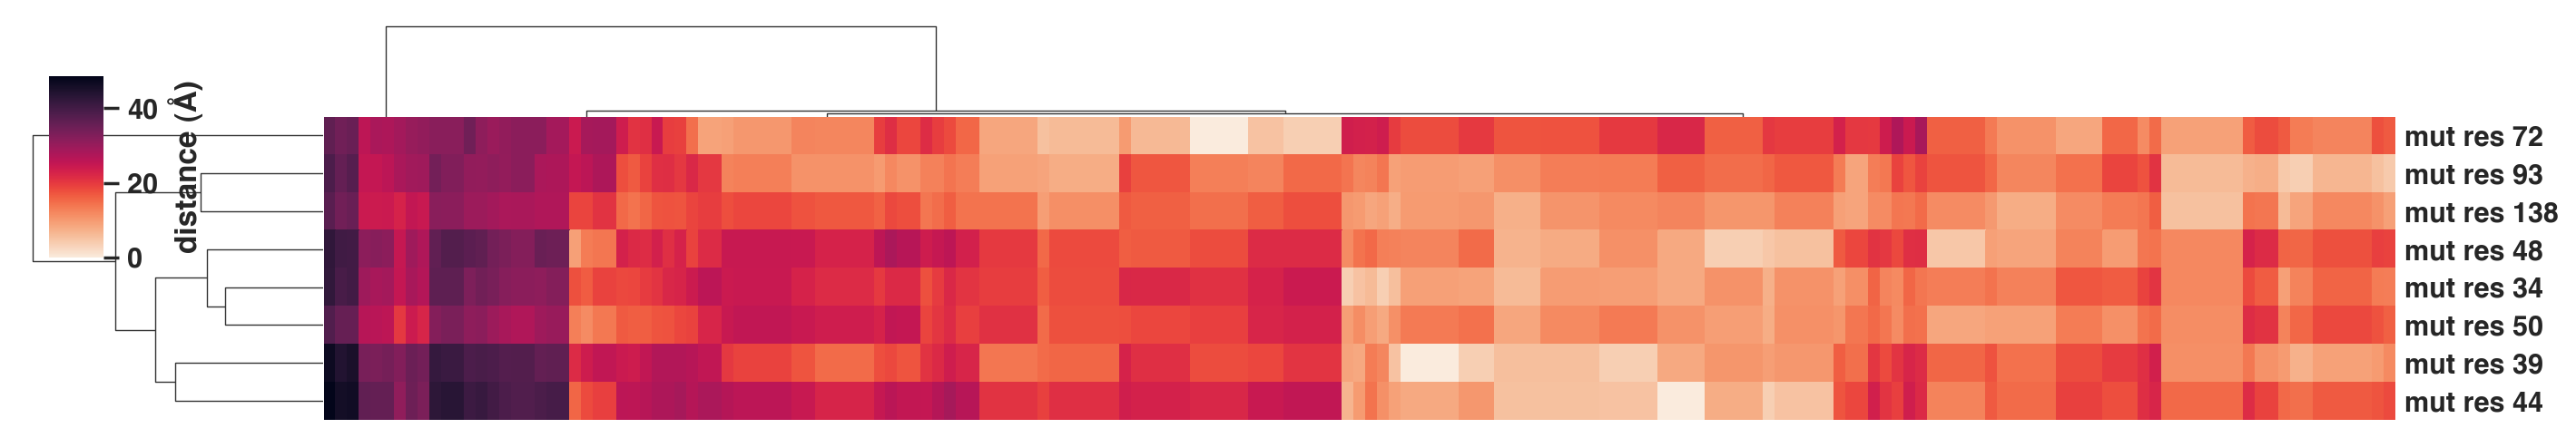

In [10]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as mpl
%matplotlib inline
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams['font.sans-serif'] = ["Helvetica"]
sns.set_context("paper")
sns.set_style("white")
sns.set(font="Helvetica")

df = res_feat_dist_df.T
cm = sns.clustermap(
    df,
#     linewidths=0.1,
    cbar_kws={'label': 'distance (Å)'},
    cbar_pos=(0.05, 0.85, 0.03, 0.10),
    yticklabels=True,
    xticklabels=True,
#     annot=True,
    cmap="rocket_r",
    col_colors=col_colors,
#     figsize=(10,10)
)
# Fix for recent matplotlib/seaborn issue
cm.ax_heatmap.set_ylim(len(df)+0, -0)

# Below is for adjusting the sizes of the dendograms and heatmaps
H = 0.425
W = 1.7
y0_offset = 0.29
x0_offset = 0.01
hm = cm.ax_heatmap.get_position()
# mpl.setp(cm.ax_heatmap.yaxis.get_majorticklabels(),fontsize=6)
# mpl.setp(cm.ax_heatmap.xaxis.get_majorticklabels(),fontsize=6)
col_dendo = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([
    col_dendo.x0 + x0_offset,
    col_dendo.y0,
    col_dendo.width*W,
    col_dendo.height*1
])
row_dendo = cm.ax_row_dendrogram.get_position()
cm.ax_row_dendrogram.set_position([
    row_dendo.x0 + 0.015,
    row_dendo.y0 + y0_offset,
    row_dendo.width*1,
    row_dendo.height*H
])
cm.ax_heatmap.set_position([
    hm.x0 + x0_offset,
    hm.y0 + y0_offset,
    hm.width*W,
    hm.height*H
])
col_color_pos = cm.ax_col_colors.get_position()
cm.ax_col_colors.set_position([
    col_color_pos.x0 + 0.01,
    col_color_pos.y0 + 0.01,
    col_color_pos.width*W,
    col_color_pos.height*H
])

# mpl.setp(cm.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cm.ax_heatmap.set_ylabel('')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.tick_params(axis='both', which='both', length=0)
# cm.fig.suptitle("3D distance between mutated AA and small active sites on GlpK", y=0.92, x=0.6)

In [11]:
mut_aa_feat_prox_df = pd.DataFrame()
df = res_feat_dist_df.T
for mut_aa, r in df.iterrows():
    min_dist_feats = r[r==r.min()]
    for feat_AA, min_dist in min_dist_feats.iteritems():
        feat = feat_AA[:feat_AA.find(" residue ")]
        mut_aa_feat_prox_df = mut_aa_feat_prox_df.append({"mut res": mut_aa.replace("mut res ", ''), "nearest feature": feat}, ignore_index=True)
mut_aa_feat_prox_df = mut_aa_feat_prox_df.set_index("mut res")
mut_aa_feat_prox_df.head()

,nearest feature
mut res,
34,MalK Crr interface
39,FrsA Crr interface
39,PtsI Crr interface
39,GlpK Crr interface
39,PtsH Crr interface


In [12]:
gene_mut_df = pd.read_pickle("./crr_mut_df.pkl")
gene_mut_df.head()

,COG links,COGs,Details,EC number links,EC numbers,Mutation Type,Position,RBS,Reference Seq,Sequence Change,...,tech_rep,temperature,terminator,mutation size,truncation,AA range,subgenic features,AA change,conservation (SIFT),stability (ΔΔGpred)
0,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,I34T (ATC→ACC),{},[],SNP,2535934.0,{},NC_000913,T→C,...,1.0,30 celsius,{},1,False,"(34, 34)","{Crr 1 PFAM domain, Helix}",I34T,True,True
1,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,F72V (TTT→GTT),{},[],SNP,2536047.0,{},NC_000913,T→G,...,1.0,30 celsius,{},1,False,"(72, 72)","{PtsG Crr interface, Crr 1 PFAM domain, PtsH C...",F72V,True,False
2,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,P138Q (CCG→CAG),{},[],SNP,2536246.0,{},NC_000913,C→A,...,1.0,30 celsius,{},1,False,"(138, 138)","{Crr 1 PFAM domain, Beta strand, PTS Crr type-...",P138Q,True,True
3,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,G93S (GGT→AGT),{},[],SNP,2536110.0,{},NC_000913,G→A,...,1.0,30 celsius,{},1,False,"(93, 93)","{Crr 1 PFAM domain, Beta strand, PTS Crr type-...",G93S,True,True
4,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,G48V (GGT→GTT),{},[],SNP,2535976.0,{},NC_000913,G→T,...,1.0,30 celsius,{},1,False,"(48, 48)","{Crr 1 PFAM domain, PTS Crr type-1 domain}",G48V,True,True


In [13]:
aa_mut_effect_df = pd.DataFrame(columns=["mutated AA", "functionally disruptive", "structurally disruptive", "nearest feature"])
for _, m in gene_mut_df.iterrows():
    if m["AA range"][0] == m["AA range"][1]:
        aa = m["AA range"][0]
        for _, r in mut_aa_feat_prox_df[mut_aa_feat_prox_df.index==str(aa)].iterrows():
            aa_mut_effect_df = aa_mut_effect_df.append({
                "mutated AA": aa,
                "functionally disruptive": m["conservation (SIFT)"],
                "structurally disruptive": m["stability (ΔΔGpred)"],
                "nearest feature": r["nearest feature"]},
                ignore_index=True)
    else:
        for aa in m["AA range"]:
            for _, r in mut_aa_feat_prox_df[mut_aa_feat_prox_df.index==str(aa)].iterrows():
                aa_mut_effect_df = aa_mut_effect_df.append({
                    "mutated AA": aa,
                    "functionally disruptive": m["conservation (SIFT)"],
                    "structurally disruptive": m["stability (ΔΔGpred)"],
                    "nearest feature": r["nearest feature"]},
                    ignore_index=True)

aa_mut_effect_df["unknown"] = aa_mut_effect_df.apply(lambda r: True if ((r["functionally disruptive"]==False) & (r["structurally disruptive"]==False)) else False, axis=1)
aa_mut_effect_df.head()

,mutated AA,functionally disruptive,structurally disruptive,nearest feature,unknown
0,34,True,True,MalK Crr interface,False
1,72,True,False,FrsA Crr interface,False
2,72,True,False,PtsI Crr interface,False
3,72,True,False,GlpK Crr interface,False
4,72,True,False,PtsH Crr interface,False


In [14]:
aa_mut_effect_df.to_pickle("./Crr_mut_res_df.pkl")  # Since this also describes the frequency of mutated residues, using it to described freq mut res per feat.

In [15]:
cnt_columns = ["unknown", "functionally disruptive", "structurally disruptive"]
feat_mut_eff_cnt_d = {f:{"functionally disruptive":0, "structurally disruptive":0, "unknown":0} for f in aa_mut_effect_df["nearest feature"].unique()}
for nf, gdf in aa_mut_effect_df.groupby("nearest feature"):
    for _, r in gdf.iterrows():
        f = r["nearest feature"]
        for c in cnt_columns:
            feat_mut_eff_cnt_d[f][c] += int(r[c])
feat_mut_eff_cnt_d

{'MalK Crr interface': {'functionally disruptive': 2,
  'structurally disruptive': 2,
  'unknown': 1},
 'FrsA Crr interface': {'functionally disruptive': 6,
  'structurally disruptive': 4,
  'unknown': 1},
 'PtsI Crr interface': {'functionally disruptive': 4,
  'structurally disruptive': 2,
  'unknown': 1},
 'GlpK Crr interface': {'functionally disruptive': 6,
  'structurally disruptive': 4,
  'unknown': 1},
 'PtsH Crr interface': {'functionally disruptive': 7,
  'structurally disruptive': 5,
  'unknown': 0},
 'PtsG Crr interface': {'functionally disruptive': 7,
  'structurally disruptive': 5,
  'unknown': 0},
 'Crr activity tele-phosphohistidine intermediate': {'functionally disruptive': 2,
  'structurally disruptive': 2,
  'unknown': 0},
 'GlpK Zinc binding site': {'functionally disruptive': 2,
  'structurally disruptive': 2,
  'unknown': 0},
 'Phosphohistidine by HPr': {'functionally disruptive': 2,
  'structurally disruptive': 2,
  'unknown': 0}}

In [16]:
cnt_df = pd.DataFrame(feat_mut_eff_cnt_d).T
cnt_df["total"] = cnt_df.sum(axis=1)
cnt_df

,functionally disruptive,structurally disruptive,unknown,total
MalK Crr interface,2,2,1,5
FrsA Crr interface,6,4,1,11
PtsI Crr interface,4,2,1,7
GlpK Crr interface,6,4,1,11
PtsH Crr interface,7,5,0,12
PtsG Crr interface,7,5,0,12
Crr activity tele-phosphohistidine intermediate,2,2,0,4
GlpK Zinc binding site,2,2,0,4
Phosphohistidine by HPr,2,2,0,4


In [17]:
cnt_df.to_pickle("./crr_feat_mut_eff_cnt_df.pkl")